# Univariate Process Kalman Filtering Example

In this Jypyter notebook we implement the example given on pages 11-15 of [An Introduction to the Kalman Filter](http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html) by Greg Welch and Gary Bishop. It is written in the spirit of Andrew Straw's [SciPy cookbook](http://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html). Our aim is to show how one can use the higher-level TSA routines in this simple setting.

In [8]:
import os, sys
sys.path.append(os.path.abspath('../../main/python'))

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from thalesians.tsa.distrs import NormalDistr as N
import thalesians.tsa.filtering as filtering
import thalesians.tsa.filtering.kalman as kalman
import thalesians.tsa.processes as proc
import thalesians.tsa.pypes as pypes
import thalesians.tsa.random as rnd
import thalesians.tsa.simulation as sim

In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [11]:
rnd.random_state(np.random.RandomState(seed=42), force=True)

In [12]:
pype = pypes.Pype(pypes.Direction.OUTGOING, name='FILTER', port=5758)

In [13]:
n = 100                             # number of itrations
x = -0.37727                        # true value
z = np.random.normal(x, .1, size=n) # observations (normal about x, sd=0.1)
posteriors = np.zeros(n)            # a posteri estimate of x
P = np.zeros(n)                     # a posteri error estimate
priors = np.zeros(n)                # a priori estimate of x
Pminus = np.zeros(n)                # a priori error estimate
P[0] = 1.0

Q = 1e-5                            # process variance
R = 0.1**2                          # estimate of measurement variance (change to see the effect)

# Instantiate the process
W = proc.WienerProcess(mean=0, vol=Q)

# Insantiate the filter
kf = kalman.KalmanFilter(time=0, state_distr=N(0.,1.), process=W, pype=pype)
observable = kf.create_named_observable('noisy observation', kalman.KalmanFilterObsModel.create(1.), W)


for k in range(0, n):
    prior = observable.predict(k)
    P[k] = prior.distr.cov[0][0]
    obs = observable.observe(time=k, obs=N(z[k], R), true_value=x)
    posterior = observable.predict(k)
    posteriors[k] = posterior.distr.mean[0][0]

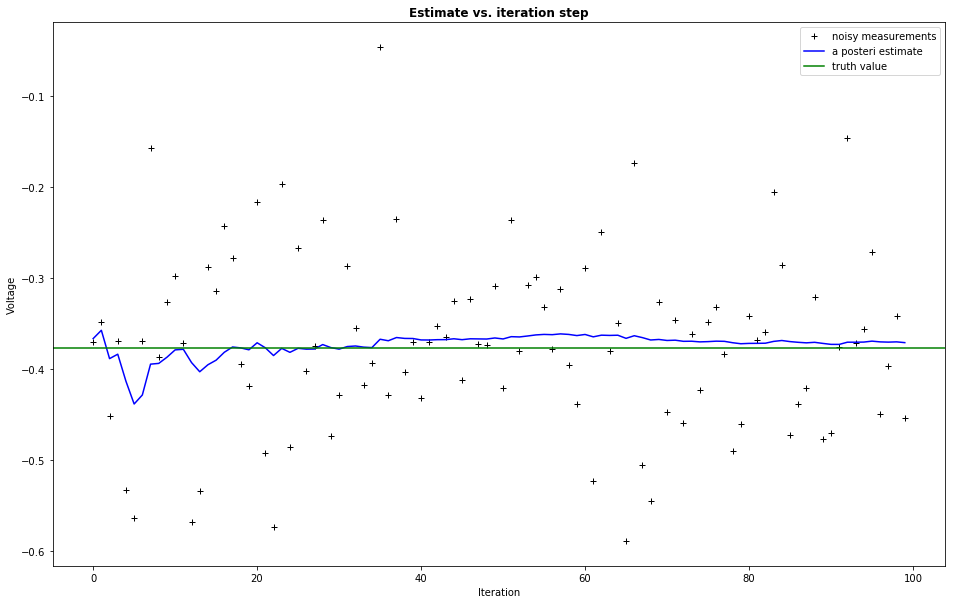

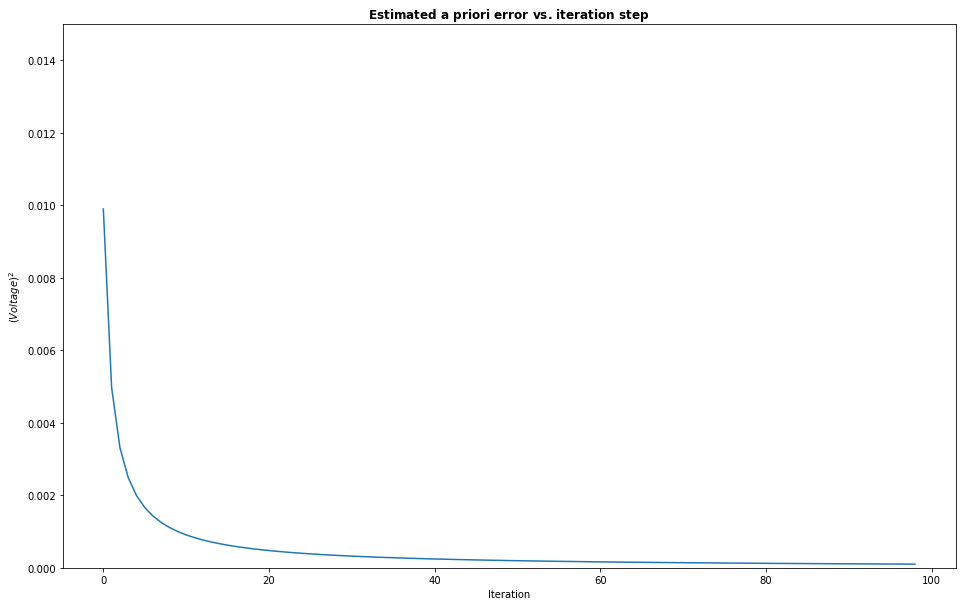

In [7]:
plt.figure()
plt.plot(z, 'k+', label='noisy measurements')
plt.plot(posteriors, 'b-', label='a posteri estimate')
plt.axhline(x, color='g', label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
plt.plot(P[1:], label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.ylim([0, 0.015])
plt.show()



In [14]:
pype.close()